# Capstone Project: Criminal Case Database

### Overall Contents:
- Background
- Webscraping Lawnet
- Webscraping Singapore Statutes
- Natural Language Pocessing
- [Search Function](5.-Search-Function) **(In this notebook)**
- Flask and Google App Engine
- Conclusion and Recommendation

## Datasets

For the search function, I will use the database which I created previously. 

The datasets that I will use are as follows:- 

* database.csv


## 5. Search Function  

The goal of the project is to create a database where users can search for and be shown judgments based on different criteria such as statutes, crimes, or case names.  

Hence it will be necessary to write some functions to allow this searching of the database.  

Regular expressions such as those used in the NLP system will be used as rules to classify the searches to appropriately match within the different columns of the database.

### 5.1 Libraries Import  

I will be using `pandas` to explore the data, `re` for regular expressions, and `matplotlib` for plotting.

In [12]:
# Imports:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [13]:
# Increase the max column width
pd.set_option('display.max_colwidth', 300)

### 5.2 Data Import

In [14]:
# Import database of judgments which were processed in the previous notebook.
database = pd.read_csv('../data/database.csv')

In [15]:
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   case_name              127 non-null    object
 1   tribunal/court         127 non-null    object
 2   decision_date          127 non-null    object
 3   possible_titles        126 non-null    object
 4   possible_statutes      126 non-null    object
 5   citations              122 non-null    object
 6   mitigation_discussed   127 non-null    int64 
 7   aggravation_discussed  127 non-null    int64 
 8   court_tag              127 non-null    object
 9   link                   127 non-null    object
dtypes: int64(2), object(8)
memory usage: 10.0+ KB


### 5.3 Search term conversion  

The first function will convert the `input` string into a standard format to ensure that the search runs smoothly.

This has to first identify the type of search to perform changes to the `input_string` to ensure that it is in an acceptable format.  

It will lower case all input strings and if there is a section number, it will only return the digits with the statute name.

In [25]:
def classify_search(input_string):
    """
    Input: An `input_string` as dtype string
    Output: The `input_string` in lowercase, with `section` or `s` removed from the section portion if available.
    """
    # Check if `input_string` contains `Act` or `Code`
    if re.search('[Aa]ct|[Cc]ode', input_string):
        try:
            # Lowercase the input_string
            section = re.search('(([Ss](ection|)(s|) |)\d+)', input_string.lower()).group(0).strip()
            
            # Remove the section or s portion and return only the digit
            section_num = re.sub('([Ss](ection|)(s|) )', "", section)
        except:
            # If no section number found, just leave it blank
            section_num = ""
            
        # Lowercase the statute name
        statute = re.search(r'((([A-Za-z]*)|(of| )*)*([Aa]ct|[Cc]ode))', input_string.lower()).group(0).strip()
        
        # Combine section number and statute name
        section_statute = section_num + " " + str.lower(statute)
        
        # Return section number and statute name combined
        return section_statute
    
    # If input_string contains `v` within spaces, extract and lowercase the case name.
    elif re.search(' [Vv] ', input_string):
        temp_case_name = re.search('(([A-Za-z]*)(([A-Za-z]*)|(a\/l|a\/p|d\/o|s\/o| |bte|bin|and|another|anr|binti|de|the|for|other|matters))* v (([A-Za-z]*)|(s\/o| |bte|bin|and|another|anr|binti|de|the|for|other|matters))*(?=|))', input_string.lower()).group(0).strip()
        case_name = str.lower(temp_case_name)
        
        # Return the case name
        return case_name
    
    # If other input_string, just lowercase it
    else:
        return str.lower(input_string)

### 5.4 Search algorithm

The search algorithm will first classify the `input_string` accord to the patterns found within to identify which column to perform the search in.  

Next, it will filter to all rows which contain the `input_string` in that column.  

Finally, it returns a resulting dataframe that contains the important columns. The court_tag is not important as that is for the NLP system to run smoothly.

In [17]:
def search_search(input_string):
    """
    Input: An `input_string` as dtype string
    Output: A dataframe of rows from the database which contain the `input_string` in the relevant column.
    """
    # Call the classify_search function to convert the `input_string`
    search_string = classify_search(input_string)
    
    # Load the database
    database = pd.read_csv('../data/database.csv')
    
    # Check if the input_string contains `act` or `code` which classifies it as a statute search and filter the database accordingly
    if re.search('act|code', search_string):
        temp = database.copy().dropna()
        temp1 = temp['possible_statutes'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp1.str.contains(search_string)].index)]
        return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
    
    # Check if the input_string contains ` v ` which classifies it as a case_name search and filter the database accordingly
    elif re.search(' v ', search_string):
        temp = database.copy()
        temp1 = temp['case_name'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp1.str.contains(search_string)].index)]
        return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
    
    # If it doesn't fit in the above, try searching in all the columns
    else:
        # First check if the input_string is matched in `case_name`
        temp = database.copy()
        temp1 = temp['case_name'].apply(lambda x: x.lower())
        result = database.loc[list(temp[temp1.str.contains(search_string)].index)]
        
        # If no results in `case_name`, search within `possible_offences`
        if len(result) == 0:
            temp = database.copy().dropna()
            temp2 = temp['possible_titles'].apply(lambda x: x.lower())
            result = database.loc[list(temp[temp2.str.contains(search_string)].index)]
            
            # If no results within `possible offences`, search within `possible_statutes`
            if len(result) == 0:
                temp3 = temp['possible_statutes'].apply(lambda x: x.lower())
                result = database.loc[list(temp[temp3.str.contains(search_string)].index)]
                
                # If still no results found, return a `no results found` message.
                if len(result) == 0:
                    print('''No results found.
                    Please ensure your search is in the following format:
                    Case Name (e.g. John v Smith),
                    Part of offence name (e.g. Forgery - try to avoid), or
                    Statute name (e.g. Section 33 Criminal Procedure Code)''')
                else:
                    return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
            else:
                return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]
        else:
            return result[['tribunal/court','case_name','decision_date','aggravation_discussed','mitigation_discussed','citations','possible_titles','possible_statutes','link']]

### 5.5 Search statistics  

The final function created is to return the relevant statistics from the filtered results of the search.  

The statistics which I have come up with are:  
- `mitigation_rate`: The mean of `mitigation_discussed` for the search  
- `aggravated_rate`: The mean of `aggravation_discussed` for the search  
- `top cited cases`: The top 10 cited cases for this search.  

For the `mitigation_rate` and `aggravated_rate`, this is simply done by finding the means of these two columns as they are binary.  

For the `top cited cases`, this is achieved by splitting the values in the `citations` column for the search results and dummifying the resulting values. This results in columns where the the sum of each case cited can be found, to find out which are the top cited cases.  

This is then used to plot a horizontal bar plot to visualize the `top cited cases`.

In [23]:
def search_statistics(input_string):
    """
    Input: `input_string` as dtype string.
    Output: `mitigation_rate` as a percentage, `aggravated_rate` as a percentage, `top cited cases`,
    `results` dataframe containing filtered results of the search, plot of `top cited cases`
    """
    # Create variable for the results of the search_search function
    results = search_search(input_string)
    results = results.reset_index(drop=True)
    
    # Calculate mean of `mitigation_discussed` to find `mitigation_rate`
    mitigation_rate = results.mitigation_discussed.mean()
    
    # Calculate mean of `aggravation_discussed` to find `aggravated_rate`
    aggravated_rate = results.aggravation_discussed.mean()
    
    # Create citations dataframe
    citations = pd.DataFrame(results['citations'])
    
    # Split the values of the `citations` column
    citations['citations'] = citations['citations'].apply(lambda x: x.split(','))
    
    # Dummify the columns of the split results.
    citations2 = pd.DataFrame(pd.get_dummies(citations['citations'].apply(pd.Series).stack()).sum(level=0))
    
    # Print the statistics
    print(f'''Mitigating factors were discussed in {mitigation_rate*100}% of the cases for this search.
Aggravating factors were discussed in {aggravated_rate*100}% of the cases for this search.

The top cited cases for this search are: 
{citations2.sum().sort_values(ascending=False).head(10)}''')
    
    # Create a plot for the `top cited cases`
    plt.figure(figsize = (10,8))
    citations2.sum().sort_values(ascending=False).head(10)[::-1].plot(kind='barh')
    plt.title('Most cited cases in this search')
    plt.xlabel('Frequency (expressed as decimal)')
    
    # Save the plot
    plt.savefig('../images/search.png', bbox_inches='tight')
    plt.show()

    # Return results
    return results;

### 5.6 Testing the functions  

I will test the functions above on a sample input string "FORGERY"

Mitigating factors were discussed in 53.84615384615385% of the cases for this search.
Aggravating factors were discussed in 33.33333333333333% of the cases for this search.

The top cited cases for this search are: 
Moad Fadzir bin Mustaffa v Public Prosecutor                         7
Kreetharan s/o Kathireson v Public Prosecutor and other matters      6
Vasentha d/o Joseph v Public Prosecutor                              6
Ramesh a/l Perumal v Public Prosecutor and another                   5
Suventher Shanmugam v Public Prosecutor                              5
Public Prosecutor v Tan Lye Heng                                     4
Adili Chibuike Ejike v Public Prosecutor                             4
Gobi a/l Avedian v Public Prosecutor                                 4
Syed Suhail bin Syed Zin v Public Prosecutor                         4
Mohammad Azli bin Mohammad Salleh v Public Prosecutor and another    4
dtype: int64


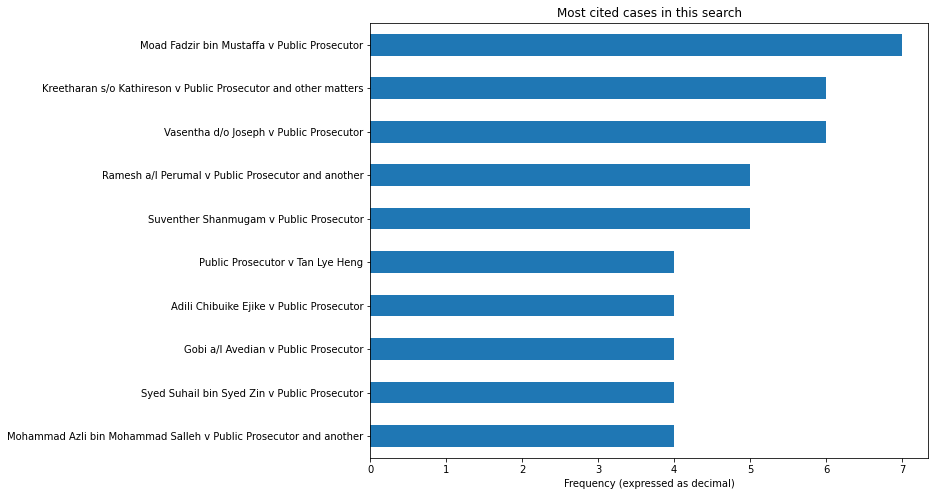

,tribunal/court,case_name,decision_date,aggravation_discussed,mitigation_discussed,citations,possible_titles,possible_statutes,link
0,Court of Appeal,Chander Kumar a/l Jayagaran v Public Prosecutor [2021] SGCA 3,18 January 2021,0,1,"Ramesh a/l Perumal v Public Prosecutor and another,Syed Suhail bin Syed Zin v Public Prosecutor,Kreetharan s/o Kathireson v Public Prosecutor and other matters,Moad Fadzir bin Mustaffa v Public Prosecutor","Not in database,Possession and consumption of controlled drugs,Punishment for offences,Trafficking in controlled drugs","33 Misuse of Drugs Act,33 Criminal Procedure Code,5 Misuse of Drugs Act,5 Criminal Procedure Code,405 Misuse of Drugs Act,405 Criminal Procedure Code,8 Misuse of Drugs Act,8 Criminal Procedure Code,394 Misuse of Drugs Act,394 Criminal Procedure Code",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_d...
1,General Division of the High Court,Public Prosecutor v Salzawiyah bte Latib and others [2021] SGHC 17,26 January 2021,1,1,"Vasentha d/o Joseph v Public Prosecutor,Public Prosecutor v Lai Teck Guan,Public Prosecutor v Tan Lye Heng,Suventher Shanmugam v Public Prosecutor,Sim Gek Yong v PP,Public Prosecutor v Rahmat Bin Abdullah and Another,Public Prosecutor v UI,Angliss Singapore Pte Ltd v Public Prosecutor,Sim Gek Yo...","Not in database,Possession and consumption of controlled drugs,Punishment for offences,Trafficking in controlled drugs,Punishment for voluntarily causing grievous hurt,Punishment","33 Criminal Procedure Code,33 Misuse of Drugs Act,33 Penal Code,5 Criminal Procedure Code,5 Misuse of Drugs Act,5 Penal Code,143 Criminal Procedure Code,143 Misuse of Drugs Act,143 Penal Code,8 Criminal Procedure Code,8 Misuse of Drugs Act,8 Penal Code,325 Criminal Procedure Code,325 Misuse of D...",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_d...
2,General Division of the High Court,Public Prosecutor v Salzawiyah bte Latib and others [2021] SGHC 16,26 January 2021,0,0,"Chai Chien Wei Kelvin v Public Prosecutor,Public Prosecutor v Mohamed Ansari bin Mohamed Abdul Aziz and another,Koh Aik Siew v PP,Chai Chien Wei Kelvin v PP,Panya Martmontree v PP,Sulaiman bin Jumari v Public Prosecutor,Public Prosecutor v Sibeko Lindiwe Mary,Lu Lai Heng v Public Prosecutor,Publ...","Abetment of offence punishable with imprisonment,Import and export of controlled drugs,Not in database,Effacing any writing from a substance bearing a Government stamp, or removing from a document a stamp used for it, with intent to cause loss to Government,Punishment for offences,Trafficking in...","230 Criminal Procedure Code,230 Misuse of Drugs Act,230 Penal Code,230 Evidence Act,24 Criminal Procedure Code,24 Misuse of Drugs Act,24 Penal Code,24 Evidence Act,116 Criminal Procedure Code,116 Misuse of Drugs Act,116 Penal Code,116 Evidence Act,33 Criminal Procedure Code,33 Misuse of Drugs Ac...",https://www.lawnet.sg/lawnet/web/lawnet/free-resources?p_p_id=freeresources_WAR_lawnet3baseportlet&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&p_p_col_id=column-1&p_p_col_pos=2&p_p_col_count=3&_freeresources_WAR_lawnet3baseportlet_action=openContentPage&_freeresources_WAR_lawnet3baseportlet_d...
3,General Division of the High Court,Public Prosecutor v Roszaidi bin Osman [2021] SGHC 22,01 February 2021,0,0,"Mohammad Azli bin Mohammad Salleh v Public Prosecutor and another,Nagaenthran a/l K Dharmalingam v Public Prosecutor and another","Not in database,Punishment for offences,Trafficking in controlled drugs,Punishment for robbery,Murder","3

In [24]:
input_string = 'misuse of drugs act'
search_statistics(input_string)

## Observations  

The functions seem to work well and the expected statistics, dataframe, and plot are returned. The results all contain the word `forgery` in the `possible_offences`, which is the correct column.  

Hence the search engine seems to be a success.